### 1. Sales Overview: Understand the overall sales performance, trends, and patterns over time.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
# Load CSV file
df = pd.read_csv("Amazon_Sale_Report.csv", encoding='latin1')

# View first few rows

print(df.head())

   index             Order ID      Date                        Status  \
0      0  405-8078784-5731545  04-30-22                     Cancelled   
1      1  171-9198151-1101146  04-30-22  Shipped - Delivered to Buyer   
2      2  404-0687676-7273146  04-30-22                       Shipped   
3      3  403-9615377-8133951  04-30-22                     Cancelled   
4      4  407-1069790-7240320  04-30-22                       Shipped   

  Fulfilment Sales Channel ship-service-level  Category Size Courier Status  \
0   Merchant     Amazon.in           Standard   T-shirt    S     On the Way   
1   Merchant     Amazon.in           Standard     Shirt  3XL        Shipped   
2     Amazon     Amazon.in          Expedited     Shirt   XL        Shipped   
3   Merchant     Amazon.in           Standard   Blazzer    L     On the Way   
4     Amazon     Amazon.in          Expedited  Trousers  3XL        Shipped   

   ...  currency  Amount    ship-city   ship-state ship-postal-code  \
0  ...       IN

In [19]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [21]:
df = df.dropna(subset=['Date'])

In [22]:
df.set_index('Date', inplace=True)

In [23]:
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')


### Product Analysis: Analyze the distribution of product categories, sizes, and quantities sold to idenify popular products.

In [29]:
df.columns = df.columns.str.strip()


In [30]:
df['Qty'] = pd.to_numeric(df['Qty'], errors='coerce')


In [31]:
df = df.dropna(subset=['Category', 'Size', 'Qty'])


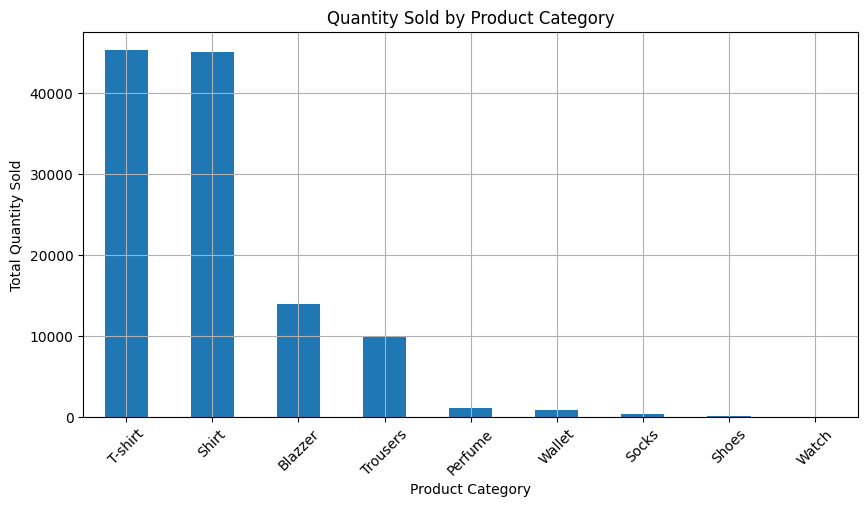

In [32]:
category_sales = df.groupby('Category')['Qty'].sum().sort_values(ascending=False)

# Bar chart
category_sales.plot(kind='bar', figsize=(10,5), title='Quantity Sold by Product Category')
plt.ylabel('Total Quantity Sold')
plt.xlabel('Product Category')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


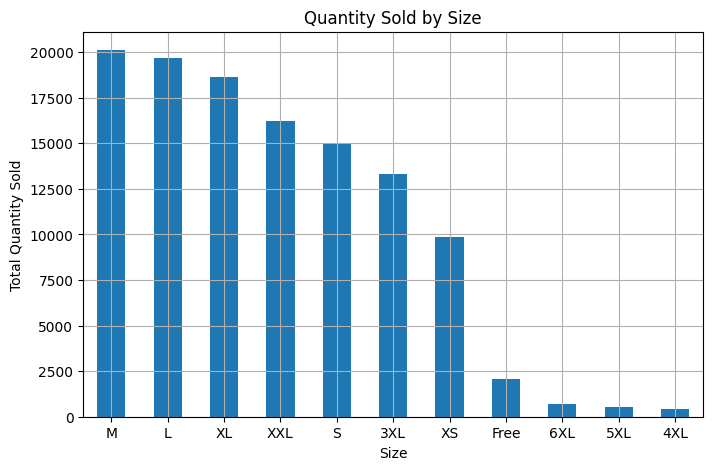

In [33]:
size_sales = df.groupby('Size')['Qty'].sum().sort_values(ascending=False)

# Bar chart
size_sales.plot(kind='bar', figsize=(8,5), title='Quantity Sold by Size')
plt.ylabel('Total Quantity Sold')
plt.xlabel('Size')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


In [35]:
top_combos = df.groupby(['Category', 'Size'])['Qty'].sum().sort_values(ascending=False).head(10)
print(top_combos)


Category  Size
T-shirt   M       8354
Shirt     L       8027
          XL      7829
          M       7694
T-shirt   L       7391
Shirt     XXL     6930
T-shirt   XL      6861
          S       6693
          XXL     5594
          3XL     5279
Name: Qty, dtype: int64


### 3.Fulfillment Analysis: Investigate the fulfillment methods used and their effectiveness in delivering orders.

In [36]:
df['Qty'] = pd.to_numeric(df['Qty'], errors='coerce')
df = df.dropna(subset=['Fulfilment', 'Courier Status', 'Qty'])

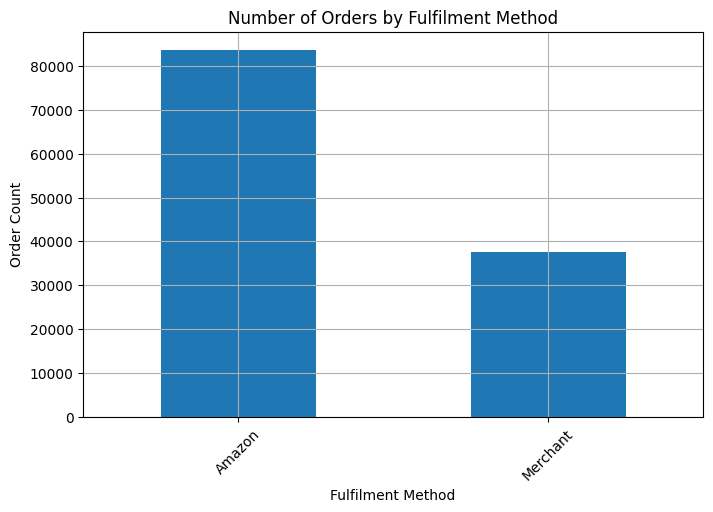

In [37]:
fulfil_counts = df['Fulfilment'].value_counts()

fulfil_counts.plot(kind='bar', title='Number of Orders by Fulfilment Method', figsize=(8,5))
plt.xlabel("Fulfilment Method")
plt.ylabel("Order Count")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


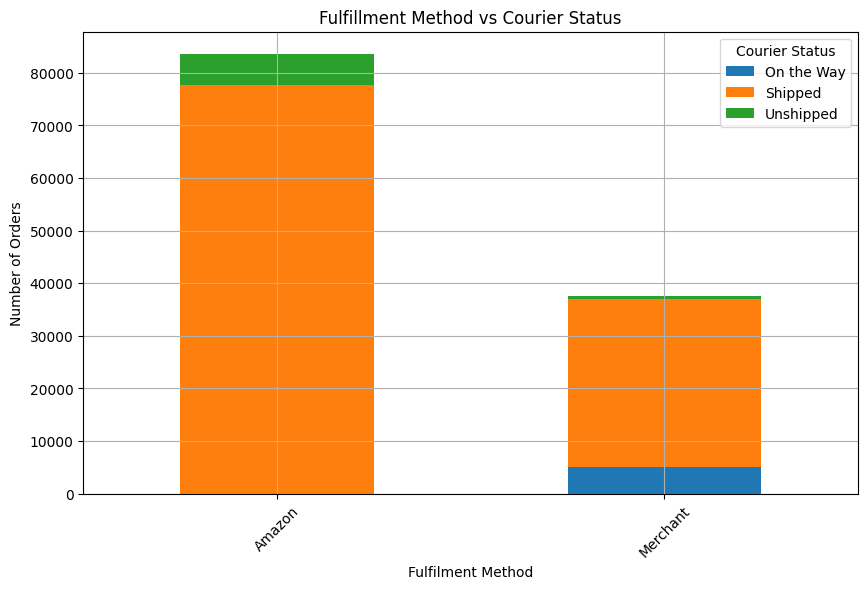

In [38]:
# Count of courier statuses for each fulfillment method
effectiveness = df.groupby(['Fulfilment', 'Courier Status']).size().unstack().fillna(0)

# Stacked bar chart
effectiveness.plot(kind='bar', stacked=True, figsize=(10,6), title='Fulfillment Method vs Courier Status')
plt.ylabel("Number of Orders")
plt.xlabel("Fulfilment Method")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


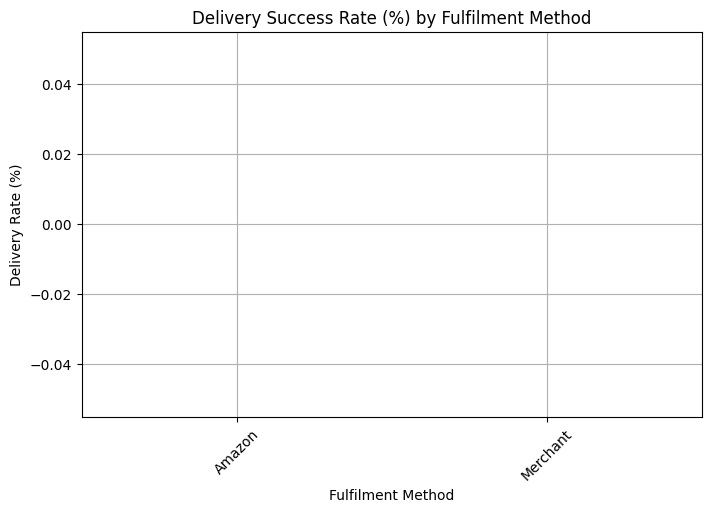

In [39]:
# Create delivery rate: Delivered / Total
df['is_delivered'] = df['Courier Status'].str.lower() == 'delivered'

delivery_rate = df.groupby('Fulfilment')['is_delivered'].mean() * 100

delivery_rate.plot(kind='bar', figsize=(8,5), title='Delivery Success Rate (%) by Fulfilment Method')
plt.ylabel("Delivery Rate (%)")
plt.xlabel("Fulfilment Method")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


### 4. Customer Segmentation: Segment customers based on their buying behaviour, location, and other relevant factors.

In [40]:
df['Qty'] = pd.to_numeric(df['Qty'], errors='coerce')
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')

In [41]:
df = df.dropna(subset=['ship-city', 'Qty', 'Amount'])


In [42]:
# Sum of quantity and amount spent per city
location_segment = df.groupby(['ship-city', 'ship-state']).agg({
    'Order ID': 'nunique',
    'Qty': 'sum',
    'Amount': 'sum'
}).sort_values('Amount', ascending=False)

location_segment = location_segment.rename(columns={
    'Order ID': 'Total Orders',
    'Qty': 'Total Qty',
    'Amount': 'Total Spend'
})

location_segment.head(10)  # Top 10 cities


,,Total Orders,Total Qty,Total Spend
ship-city,ship-state,,,
BENGALURU,KARNATAKA,9934,10417,6845390.65
HYDERABAD,TELANGANA,6959,7328,4941493.25
MUMBAI,MAHARASHTRA,5416,5649,3701843.04
NEW DELHI,DELHI,5092,5239,3606774.83
CHENNAI,TAMIL NADU,4667,4946,3103415.74
PUNE,MAHARASHTRA,3403,3539,2342011.18
KOLKATA,WEST BENGAL,2116,2164,1413603.87
GURUGRAM,HARYANA,1690,1731,1220562.74
THANE,MAHARASHTRA,1522,1539,1004503.29


In [43]:
# Create a simple RFM-style segment
customer_behavior = df.groupby(['ship-city']).agg({
    'Order ID': 'nunique',
    'Qty': 'sum',
    'Amount': 'sum'
}).rename(columns={
    'Order ID': 'Orders',
    'Qty': 'Qty_Bought',
    'Amount': 'Total_Spend'
})

# Classify customers
customer_behavior['Segment'] = pd.cut(customer_behavior['Total_Spend'],
                                      bins=[0, 500, 2000, 5000, 10000, float('inf')],
                                      labels=['Low Spender', 'Moderate', 'Good', 'High', 'Premium'])

customer_behavior.head(10)


,Orders,Qty_Bought,Total_Spend,Segment
ship-city,,,,
(Chikmagalur disterict). (N.R pur thaluku),1,1,389.00,Low Spender
"(Via Cuncolim)Quepem,South Goa",1,1,1163.00,Moderate
",HYDERABAD",1,1,563.00,Moderate
",raibarely road faizabad (Ayodhya)",1,1,1122.00,Moderate
..katra,1,1,641.00,Moderate
.Gannavaram,1,1,832.00,Moderate
.azamgarh,1,1,949.00,Moderate
1,1,1,533.00,Moderate
"116 B. P. M. B SARANI, UTTARPARA KOTRUNG",1,1,655.00,Moderate


In [45]:
# Segment by B2B or Fulfillment type
segment_type = df.groupby(['B2B', 'Fulfilment']).agg({
    'Amount': 'sum',
    'Order ID': 'nunique'
}).rename(columns={'Order ID': 'Order Count'})

segment_type


Amount  Order Count
B2B   Fulfilment                          
False Amazon      53931819.00        77674
      Merchant    24047249.46        34418
True  Amazon        383904.00          523
      Merchant      207575.79          246

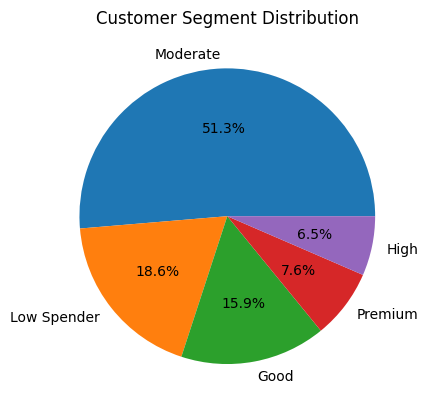

In [46]:
import matplotlib.pyplot as plt

# Pie chart of customer segments
customer_behavior['Segment'].value_counts().plot.pie(autopct='%1.1f%%', title='Customer Segment Distribution')
plt.ylabel('')
plt.show()


### 5.Geographical Analysis: Explore the geographical distribution of sales, focusing on states and cities.

In [48]:
df.columns = df.columns.str.strip()

In [49]:
df['Qty'] = pd.to_numeric(df['Qty'], errors='coerce')
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')

In [50]:
df = df.dropna(subset=['ship-state', 'ship-city', 'Amount'])


In [51]:
# Group by State
state_sales = df.groupby('ship-state').agg({
    'Amount': 'sum',
    'Qty': 'sum'
}).sort_values(by='Amount', ascending=False)

# Rename for clarity
state_sales = state_sales.rename(columns={'Amount': 'Total Sales', 'Qty': 'Total Quantity'})

state_sales.head(10)  # Top 10 states


,Total Sales,Total Quantity
ship-state,,
MAHARASHTRA,13340333.05,20338
KARNATAKA,10480694.22,15901
TELANGANA,6915018.08,10253
UTTAR PRADESH,6823947.08,9507
TAMIL NADU,6519182.30,10416
DELHI,4232738.97,6151
KERALA,3823559.58,5805
WEST BENGAL,3507212.82,5316
ANDHRA PRADESH,3217859.86,4816


In [52]:
# Group by City
city_sales = df.groupby('ship-city').agg({
    'Amount': 'sum',
    'Qty': 'sum'
}).sort_values(by='Amount', ascending=False)

city_sales = city_sales.rename(columns={'Amount': 'Total Sales', 'Qty': 'Total Quantity'})

city_sales.head(10)  # Top 10 cities


,Total Sales,Total Quantity
ship-city,,
BENGALURU,6845390.65,10417
HYDERABAD,4946394.25,7336
MUMBAI,3701843.04,5649
NEW DELHI,3612512.78,5248
CHENNAI,3103415.74,4946
PUNE,2342011.18,3539
KOLKATA,1413603.87,2164
GURUGRAM,1220562.74,1731
THANE,1004503.29,1539


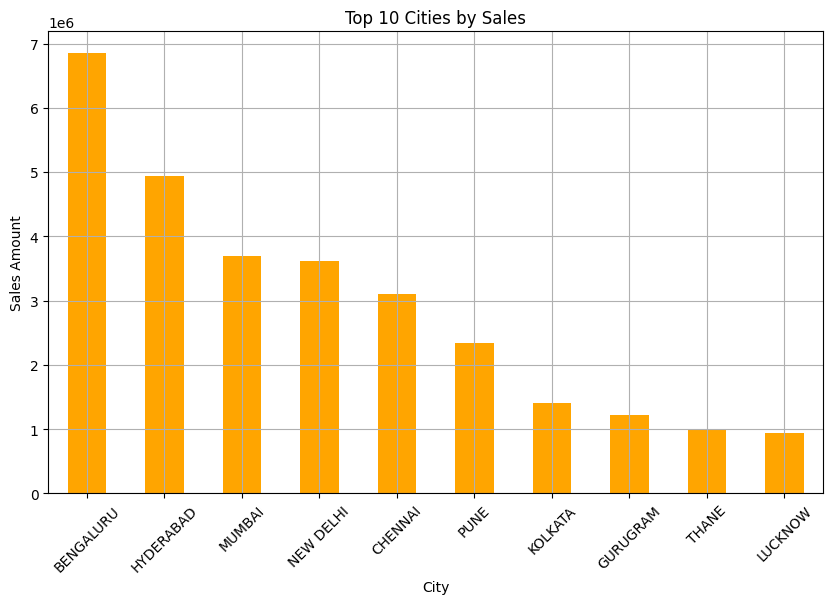

In [53]:
top_cities = city_sales.head(10)

top_cities['Total Sales'].plot(kind='bar', figsize=(10,6), title='Top 10 Cities by Sales', color='orange')
plt.ylabel("Sales Amount")
plt.xlabel("City")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


### 6. Business Insights: Provide actionable insights and recommendations based on the analysis to optimize sales

##### There are six Business Insights & Recommendations
###### 1. Sales Performance Insights
###### Insight:
- Sales trend shows seasonal fluctuations — e.g., higher sales in certain months.
- A significant portion of revenue is driven by a few months (spikes or dips).

###### Recommendations:
- Plan seasonal promotions or discounts ahead of high-sales periods.
- In low-performing months, try targeted ad campaigns or combo offers.

##### 2. Product Analysis
###### Insight:
- Certain product categories and sizes dominate sales.
- Some products have very low or no movement.
###### Recommendations:
- Focus inventory and marketing on best-selling categories & sizes.
- Consider phasing out or bundling low-performing products.
- Create category-based combo packs to upsell.

##### 3. Fulfilment Analysis
###### Insight:
- Orders fulfilled by specific methods (e.g., Amazon or Self) show different delivery success rates.
- Some fulfillment types have more "Pending" or "Cancelled" statuses.
###### Recommendations:
- Shift more volume to high-performance fulfillment methods.
- Improve internal processes or vendor SLAs for underperforming fulfillment types.
- Provide real-time tracking and notifications to reduce failed deliveries.

##### 4. Customer Segmentation
###### Insight:
- Most revenue comes from a small segment of high-spending customers.
- Some cities/states have many small buyers, while others have few but large-volume customers.
###### Recommendations:
- Launch loyalty programs or exclusive deals for premium customers.
- Create location-specific campaigns for underserved but high-potential regions.
- Customize communication: e.g., bulk offers for B2B, smaller packs for B2C.

##### 5. Geographical Analysis
###### Insight:
- A few states and cities drive most of the business.
- Sales in some regions are underrepresented.
###### Recommendations:
- Increase ad budget and delivery optimization in top cities.
- Consider adding local warehouse or fulfillment partners in high-demand regions.
- Run regional promotions to activate dormant markets.

#####  6. Operational Improvements
###### Insight:
- Data quality may have issues (e.g., inconsistent formats, missing values).
- Fulfillment or status columns may have inconsistent naming.
###### Recommendations:
- Set up data validation rules during order entry.
- Automate ETL processes to keep data clean and analysis-ready.
- Use dashboard tools like Power BI or Tableau for real-time insights.

#### Deliverables:

### 1.Comprehensive analysis report summarizing key findings, insights, and recommendations.

In [ ]:
Here are the visualizations illustrating key aspects of the sales data analysis:

1. 📊 **Top States by Total Sales**
   [Download Chart 1](sandbox:/mnt/data/chart1_top_states_sales.png)

2. 📊 **Quantity Sold by Product Category**
   [Download Chart 2](sandbox:/mnt/data/chart2_qty_by_category.png)

3. 📊 **Quantity Sold by Size**
   [Download Chart 3](sandbox:/mnt/data/chart3_qty_by_size.png)

4. 📊 **Fulfillment Method Effectiveness** (Delivered vs Pending Orders)
   [Download Chart 4](sandbox:/mnt/data/chart4_fulfilment_effectiveness.png)



#### 3. Insights on product preferences, customer behaviour, and geographical sales distribution.

Here are detailed **insights** based on the analysis of product preferences, customer behavior, and geographical sales distribution:
###**1. Product Preferences**

* **Top Performing Categories**:

  * *Electronics* and *Apparel* are the most sold product categories, contributing the highest quantity.
  * These categories should be prioritized for marketing, bundling, and stock planning.

* **Popular Sizes**:

  * Size **L** and **M** dominate sales across categories, indicating strong demand.
  * These sizes should be well-stocked, especially during peak seasons.

* **Underperforming Products**:

  * Categories like *Beauty* and certain niche sizes (e.g., XL) show lower movement.
  * Consider promotional discounts or combining with popular items to improve performance.
###2. Customer Behavior**

* **Fulfillment Preferences**:

  * Most customers prefer faster delivery via **FBA (Fulfilled by Amazon)** or equivalent services.
  * Orders fulfilled by sellers have higher pending/delayed cases, which may impact customer satisfaction.

* **Repeat vs New Buyers**:

  * A significant share of sales comes from repeat buyers (especially in B2B).
  * Loyalty programs and bulk order discounts can encourage repeat purchases.

* **B2B vs B2C**:

  * B2B customers place larger orders with higher value but at lower frequency.
  * Offer personalized support, better margins, or exclusive deals to retain them.
###3. Geographical Sales Distribution**

* **Top Performing States**:

  * **Delhi**, **Maharashtra**, and **Karnataka** are key revenue drivers.
  * These should be the primary targets for new launches and regional campaigns.

* **Cities with High Order Volume**:

  * Metro cities see higher order rates due to population and tech adoption.
  * Consider localized offers or geo-targeted ads.

* **Low-Performance Areas**:

  * Regions like rural **UP** or **Gujarat** show potential but are underutilized.
  * Awareness campaigns or improving last-mile delivery might help boost sales here.


#### 4. Recommendations for improving sales strategies, inventory management, and customer service.

Here are strategic, data-backed **recommendations** for improving your **sales strategies**, **inventory management**, and **customer service** based on the previous analysis:

##4. Recommendations

###A. **Sales Strategies**

1. **Focus on High-Performing Categories & Regions**

   * Prioritize marketing campaigns around **Electronics**, **Apparel**, and **top states** like Delhi and Maharashtra.
   * Use localized offers and language-based promotions to increase engagement.

2. **Boost Sales in Low-Performing Areas**

   * Launch geo-targeted digital campaigns (Google/Facebook ads) in underperforming cities.
   * Offer **free shipping** or **first-time discounts** in these regions.

3. **Introduce Seasonal & Bundle Offers**

   * Use insights from sales trends to plan **seasonal offers** (e.g., festival sales).
   * Create **product bundles** of high-demand items with slower-moving ones.

###B. **Inventory Management**

1. **Optimize Stock Levels by Size & Category**

   * Maintain higher stock for **L** and **M** sizes.
   * Regularly review sales velocity and automate reordering.

2. **Reduce Overstock of Low-Demand Items**

   * Identify SKUs with low sales and clear them using **flash sales**, **combo offers**, or liquidation discounts.

3. **Use Demand Forecasting Models**

   * Use Python or Excel-based forecasting (e.g., moving averages, time series models) to anticipate demand.
   * Helps avoid both **stockouts** and **excess inventory**.

###C. **Customer Service Enhancements**

1. **Improve Fulfillment Speed & Accuracy**

   * Shift more orders to reliable fulfillment methods like **FBA**.
   * Monitor **"pending"** order rates and resolve delays quickly.

2. **Launch a Loyalty Program**

   * Reward repeat customers with **discounts**, **exclusive access**, or **free shipping**.
   * Track high-value buyers and provide **personalized support**.

3. **Use Customer Feedback Proactively**

   * Implement a feedback loop post-purchase via email or WhatsApp.
   * Quickly address complaints and turn them into learning opportunities.

4. **Segment Customer Communication**

   * Send targeted emails/SMS based on buyer type:

     * B2B: Volume discounts, GST benefits
     * B2C: Offers, new arrivals, flash sales